In [2]:
""" Module to compute projections on the positive simplex or the L1-ball
A positive simplex is a set X = { \mathbf{x} | \sum_i x_i = s, x_i \geq 0 }
The (unit) L1-ball is the set X = { \mathbf{x} | || x ||_1 \leq 1 }
Adrien Gaidon - INRIA - 2011
"""


import numpy as np


def euclidean_proj_simplex(v, s=1):
    """ Compute the Euclidean projection on a positive simplex
    Solves the optimisation problem (using the algorithm from [1]):
        min_w 0.5 * || w - v ||_2^2 , s.t. \sum_i w_i = s, w_i >= 0 
    Parameters
    ----------
    v: (n,) numpy array,
       n-dimensional vector to project
    s: int, optional, default: 1,
       radius of the simplex
    Returns
    -------
    w: (n,) numpy array,
       Euclidean projection of v on the simplex
    Notes
    -----
    The complexity of this algorithm is in O(n log(n)) as it involves sorting v.
    Better alternatives exist for high-dimensional sparse vectors (cf. [1])
    However, this implementation still easily scales to millions of dimensions.
    References
    ----------
    [1] Efficient Projections onto the .1-Ball for Learning in High Dimensions
        John Duchi, Shai Shalev-Shwartz, Yoram Singer, and Tushar Chandra.
        International Conference on Machine Learning (ICML 2008)
        http://www.cs.berkeley.edu/~jduchi/projects/DuchiSiShCh08.pdf
    """
    assert s > 0, "Radius s must be strictly positive (%d <= 0)" % s
    n, = v.shape  # will raise ValueError if v is not 1-D
    # check if we are already on the simplex
    if v.sum() == s and np.alltrue(v >= 0):
        # best projection: itself!
        return v
    # get the array of cumulative sums of a sorted (decreasing) copy of v
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u)
    # get the number of > 0 components of the optimal solution
    rho = np.nonzero(u * np.arange(1, n+1) > (cssv - s))[0][-1]
    # compute the Lagrange multiplier associated to the simplex constraint
    theta = float(cssv[rho] - s) / rho
    # compute the projection by thresholding v using theta
    w = (v - theta).clip(min=0)
    return w


def euclidean_proj_l1ball(v, s=1):
    """ Compute the Euclidean projection on a L1-ball
    Solves the optimisation problem (using the algorithm from [1]):
        min_w 0.5 * || w - v ||_2^2 , s.t. || w ||_1 <= s
    Parameters
    ----------
    v: (n,) numpy array,
       n-dimensional vector to project
    s: int, optional, default: 1,
       radius of the L1-ball
    Returns
    -------
    w: (n,) numpy array,
       Euclidean projection of v on the L1-ball of radius s
    Notes
    -----
    Solves the problem by a reduction to the positive simplex case
    See also
    --------
    euclidean_proj_simplex
    """
    assert s > 0, "Radius s must be strictly positive (%d <= 0)" % s
    n, = v.shape  # will raise ValueError if v is not 1-D
    # compute the vector of absolute values
    u = np.abs(v)
    # check if v is already a solution
    if u.sum() <= s:
        # L1-norm is <= s
        return v
    # v is not already a solution: optimum lies on the boundary (norm == s)
    # project *u* on the simplex
    w = euclidean_proj_simplex(u, s=s)
    # compute the solution to the original problem on v
    w *= np.sign(v)
    return w

In [3]:
def create_rad_vectors(d=500):
    vectors = np.random.randint(2, size=(d,d))
    for i in range(d):
        for j in range(d):
            if(vectors[i][j] == 0):
                vectors[i][j] -= 1
    return vectors

In [4]:
def objective(x, vectors, d=500):
    index = 0
    output = 0
    for i in range(d):
        curr_val = np.inner(vectors[i], x)
        if(curr_val >= output):
            output = curr_val
            index = i
    
    return output, index

In [55]:
def proj_subgrad(x_init, vectors, norm, max_iter, d=500):
    
    M = 0
    if(norm == 1):
        M = 1
    if(norm == 2):
        M = np.sqrt(d)
    
    x = x_init
    x_out = x_init
    
    value, index = objective(x_init, vectors)
    outputs = [value]
    outputs_unscaled = [value]
    
    a = 1
    A = a
    
    for i in range(1, max_iter):
        
        a_i = 1/(M*np.sqrt(i))
        A = A + a_i
        
        subgrad_step = np.subtract(x, a_i*vectors[index]) 
        x_i = euclidean_proj_simplex(subgrad_step)
        
        x_out = np.add(x_out, a_i*x_i)
        
        value, index = objective(x_out/A, vectors)
        value_unscaled, temp = objective(x_i, vectors)
        
        outputs = np.append(outputs, value)
        outputs_unscaled = np.append(outputs_unscaled, value_unscaled)
        
    return outputs, outputs_unscaled

In [67]:
def find_C(a_i, vectors, index, d=500):
    result = 2
    for i in range(d):
        if(vectors[index][i] <= result):
            result = vectors[index][i]
            
    return -result*a_i

def mirror(x_init, vectors, norm, max_iter, d=500):
    
    M = 0
    if(norm == 1):
        M = 1
    if(norm == 2):
        M = np.sqrt(d)
    
    x = x_init
    x_out = x_init
    
    value, index = objective(x_init, vectors)
    outputs = [value]
    outputs_unscaled = [value]
    
    a = 1
    A = a
    
    for i in range(1, max_iter):
        a_i = 1/(M*np.sqrt(i))
        a_i_trans = a_i + find_C(a_i, vectors, index)
        
        A = A + a_i
        
        x_i = np.multiply(x, np.exp(-a_i_trans*vectors[index]))
        x_i = x_i/np.sum(x_i)
        
        x = x_i
        x_out = x_out + a_i*x_i
        
        value, index = objective(x_out/A, vectors)
        outputs = np.append(outputs, value)
        
        value_unscaled, temp = objective(x_i, vectors)
        outputs_unscaled = np.append(outputs_unscaled, value_unscaled)
        
    return outputs, outputs_unscaled

In [102]:
x_init = np.ones(500)/500
vectors = create_rad_vectors()

proj_out_l1, proj_l1 = proj_subgrad(x_init, vectors, 1, 2000)
mirror_out_l1, mirror_l1 = mirror(x_init, vectors, 1, 2000)

proj_out_l2, proj_l2 = proj_subgrad(x_init, vectors, 2, 2000)
mirror_out_l2, mirror_l2 = mirror(x_init, vectors, 2, 2000)

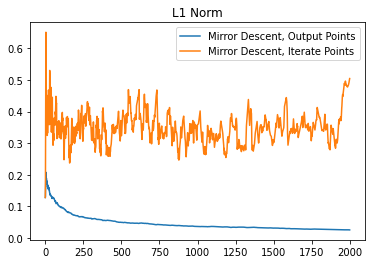

In [103]:
import matplotlib.pyplot as plt

plt.plot(mirror_out_l1, label = "Mirror Descent, Output Points")
plt.plot(mirror_l1, label = "Mirror Descent, Iterate Points")
plt.title("L1 Norm")
plt.legend()

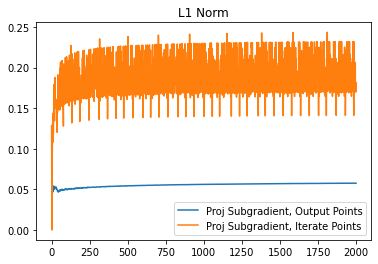

In [104]:
plt.plot(proj_out_l1, label = "Proj Subgradient, Output Points")
plt.plot(proj_l1, label = "Proj Subgradient, Iterate Points")
plt.title("L1 Norm")
plt.legend()

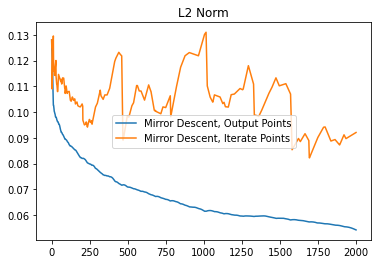

In [105]:
plt.plot(mirror_out_l2, label = "Mirror Descent, Output Points")
plt.plot(mirror_l2, label = "Mirror Descent, Iterate Points")
plt.title("L2 Norm")
plt.legend()

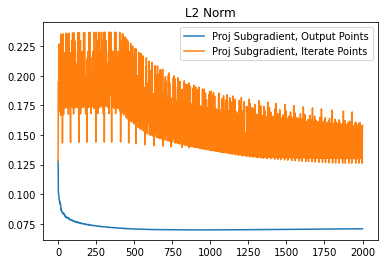

In [106]:
plt.plot(proj_out_l2, label = "Proj Subgradient, Output Points")
plt.plot(proj_l2, label = "Proj Subgradient, Iterate Points")
plt.title("L2 Norm")
plt.legend()

In [203]:
def f(B, x, b):
    return (np.matmul((np.matmul(B, x) - b).transpose(), np.matmul(B, x) - b))/2

def grad(B, x, b):
    return np.matmul(B.transpose(), np.subtract( np.matmul(B, x), b ) )

def linear_min(gradient, d=200):

    s = np.zeros((d, 1))

    if (gradient != 0).sum() == 0:
        return s

    else:
        a = abs(gradient)
        i = np.nonzero(a == max(a))[0][0]
        s[i] = - np.sign(gradient[i])
        return s
    
def frank_wolfe(B, x_init, b, max_iter, tol = 0.1, p=10, d=200):
    
    values = [f(B,x_init,b)]
    x = x_init
    
    a_i = 0
    A = 0
    
    stop_tol = 0
    sparsity = 0
    
    for i in range(1, max_iter):
        
        a_i = (i+1)/2
        
        gradient = grad(B, x, b)
        v = linear_min(gradient)
        
        x = np.add(( A/(A+a_i) )*x, ( a_i/(A+a_i) )*v.transpose())
        x = x.flatten()
        
        values = np.append(values, f(B,x,b))
        
        A = A + a_i
        
        if(values[i]/values[0] <= tol):
            if(stop_tol == 0):
                sparsity = np.count_nonzero(x)
                stop_tol = 1
            
        
    return values/values[0], sparsity

In [204]:
def proj_subgrad2(B, x_init, b, max_iter, tol = 0.1, p=10, d=200):

    values = [f(B,x_init,b)]
    x = x_init
    
    stop_tol = 0
    sparsity = -1
    
    for i in range(1, max_iter):
        L = np.linalg.norm( np.matmul(B.transpose(), B), 2)
        grad_step = x - grad(B,x,b)/L
        proj = euclidean_proj_l1ball(grad_step)
        
        x = proj
        
        values = np.append(values, f(B,x,b))
        
        if(values[i]/values[0] <= tol):
            if(stop_tol == 0):
                sparsity = np.count_nonzero(x)
                stop_tol = 1
                
    return values/values[0], sparsity

In [218]:
b = np.ones(10)
x = np.zeros(200)
x[0]=1

fw_avg_val = np.zeros(500)
pgd_avg_val = np.zeros(500)
fw_avg_sparse = 0
pgd_avg_sparse = 0

count = 0

while(count != 30):
    B = np.random.normal(0, 1, size=(10,200))
    
    values_fw, sparse_fw = frank_wolfe(B,x,b, 500)
    if(sparse_fw == -1):
        continue
    
    values_pgd, sparse_pgd = proj_subgrad2(B,x,b, 500)
    if(sparse_pgd == -1):
        continue
        
    fw_avg_val = fw_avg_val + values_fw
    fw_avg_sparse = fw_avg_sparse + sparse_fw
    
    pgd_avg_val = pgd_avg_val + values_pgd
    pgd_avg_sparse = pgd_avg_sparse + sparse_pgd

    count += 1
    
fw_avg_val = fw_avg_val/30
pgd_avg_val = pgd_avg_val/30
fw_avg_sparse = fw_avg_sparse/30
pgd_avg_sparse = pgd_avg_sparse/30

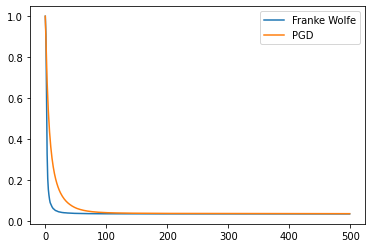

In [219]:
plt.plot(fw_avg_val, label = "Franke Wolfe")
plt.plot(pgd_avg_val, label = "PGD")
plt.legend()

In [222]:
print("average number of non-zero elements for Frank Wolfe: ", fw_avg_sparse)
print("average number of non-zero elements of PGD: ", pgd_avg_sparse)

average number of non-zero elements for Frank Wolfe:  5.433333333333334
average number of non-zero elements of PGD:  18.633333333333333
